## Lesson 4

This is the fourth in a series of lessons related to astronomy data.

As a running example, we are replicating parts of the analysis in a recent paper, "[Off the beaten path: Gaia reveals GD-1 stars outside of the main stream](https://arxiv.org/abs/1805.00425)" by Adrian M. Price-Whelan and Ana Bonaca.

In the first notebook, we wrote ADQL queries and used them to select and download data from the Gaia server.

In the second notebook, we write a query to select stars from the region of the sky where we expect GD-1 to be, and save the results in a FITS file.

In the third notebook, we read that data back and identified stars with the proper motion we expect for GD-1.

Here are the steps in this notebook:

1. Using data from the previous notebook, we'll identify the values of proper motion for stars likely to be in GD-1.

2. Then we'll compose an ADQL query that selects stars based on proper motion, so we can download only the data we need.

3. We'll also see how to write the results to a CSV file.

That will make it possible to search a bigger region of the sky in a single query.

After completing this lesson, you should be able to

* Convert proper motion between frames.

* Write an ADQL query that selects based on proper motion.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install Astroquery and a the other libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  

If you are using this notebook as part of a Carpentries workshop, you should have received setup instructions.

TODO: Add a link to the instructions.


In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala pyia python-wget

## Reload the data

The following cells download the data from the previous notebook, if necessary, and load it into a Pandas `DataFrame`.

In [2]:
import os
from wget import download

filename = 'gd1_dataframe.hdf5'
path = 'https://github.com/AllenDowney/AstronomicalData/raw/main/data/'

if not os.path.exists(filename):
    print(download(path+filename))

In [95]:
import pandas as pd

df = pd.read_hdf(filename, 'df')
centerline = pd.read_hdf(filename, 'centerline')
selected = pd.read_hdf(filename, 'selected')

## Transforming the rectangle

At this point we have downloaded data for a relatively large number of stars (more than 100,000) and selected a relatively small number (around 1000).

It would be more efficient to use ADQL to select only the stars we need.  That would also make it possible to download data covering a larger region of the sky.

However, the selection we did was based on proper motion in the `GD1Koposov10` frame.  In order to do the same selection in ADQL, we have to translate these motions into ICRS.

We'll start by creating a `GD1Koposov10` object that contains the corners of the rectangle we just selected in proper motion.

In [96]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

In [97]:
import astropy.units as u

pm1_rect = [pm1_min, pm1_min, pm1_max, pm1_max, pm1_min] * u.mas/u.yr
pm2_rect = [pm2_min, pm2_max, pm2_max, pm2_min, pm2_min] * u.mas/u.yr

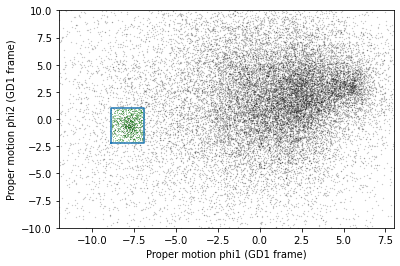

In [99]:
pm1 = centerline['pm_phi1']
pm2 = centerline['pm_phi2']
plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)

pm1 = selected['pm_phi1']
pm2 = selected['pm_phi2']
plt.plot(pm1, pm2, 'gx', markersize=0.3, alpha=0.3)

plt.plot(pm1_rect, pm2_rect, '-')
    
plt.xlabel('Proper motion phi1 (GD1 frame)')
plt.ylabel('Proper motion phi2 (GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10);

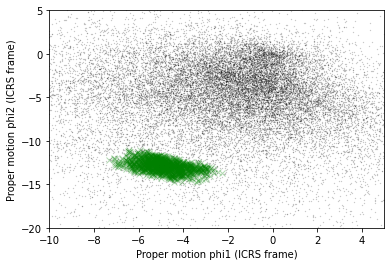

In [119]:
pm1 = centerline['pmra']
pm2 = centerline['pmdec']
plt.plot(pm1, pm2, 'ko', markersize=0.3, alpha=0.3)

pm1 = selected['pmra']
pm2 = selected['pmdec']
plt.plot(pm1, pm2, 'gx', alpha=0.3)
    
plt.xlabel('Proper motion phi1 (ICRS frame)')
plt.ylabel('Proper motion phi2 (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

In [115]:
import numpy as np

points = selected[['pmra','pmdec']].to_numpy()
points.shape

(1049, 2)

In [128]:
from scipy.spatial import ConvexHull

hull = ConvexHull(points)
hull

In [130]:
hull.vertices

array([ 692,  873,  141,  303,   42,  622,   45,   83,  127,  182, 1006,
        971,  967, 1001,  969,  940], dtype=int32)

In [143]:
pm_vertices = points[hull.vertices]
pm_vertices

array([[ -4.05037121, -14.75623261],
       [ -3.41981085, -14.72365546],
       [ -3.03521988, -14.44357135],
       [ -2.26847919, -13.7140236 ],
       [ -2.61172203, -13.24797471],
       [ -2.73471401, -13.09054471],
       [ -3.19923146, -12.5942653 ],
       [ -3.34082546, -12.47611926],
       [ -5.67489413, -11.16083338],
       [ -5.95159272, -11.10547884],
       [ -6.42394023, -11.05981295],
       [ -7.09631023, -11.95187806],
       [ -7.30641519, -12.24559977],
       [ -7.04016696, -12.88580702],
       [ -6.00347705, -13.75912098],
       [ -4.42442296, -14.74641176]])

In [157]:
t = [str(x) for x in pm_vertices.flatten()]
t

['-4.050371212154984',
 '-14.75623260987968',
 '-3.4198108491382455',
 '-14.723655456335619',
 '-3.035219883740934',
 '-14.443571352854612',
 '-2.268479190206636',
 '-13.714023598831554',
 '-2.611722027231764',
 '-13.247974712069263',
 '-2.7347140078529106',
 '-13.090544709622938',
 '-3.199231461993783',
 '-12.594265302440828',
 '-3.34082545787549',
 '-12.476119260818695',
 '-5.674894125178565',
 '-11.160833381392624',
 '-5.95159272432137',
 '-11.105478836426514',
 '-6.423940229776128',
 '-11.05981294804957',
 '-7.096310230579248',
 '-11.951878058650085',
 '-7.306415190921692',
 '-12.245599765990594',
 '-7.040166963232815',
 '-12.885807024935527',
 '-6.0034770546523735',
 '-13.759120984106968',
 '-4.42442296194263',
 '-14.7464117578883']

In [158]:
pm_point_list = ', '.join(t)
pm_point_list

'-4.050371212154984, -14.75623260987968, -3.4198108491382455, -14.723655456335619, -3.035219883740934, -14.443571352854612, -2.268479190206636, -13.714023598831554, -2.611722027231764, -13.247974712069263, -2.7347140078529106, -13.090544709622938, -3.199231461993783, -12.594265302440828, -3.34082545787549, -12.476119260818695, -5.674894125178565, -11.160833381392624, -5.95159272432137, -11.105478836426514, -6.423940229776128, -11.05981294804957, -7.096310230579248, -11.951878058650085, -7.306415190921692, -12.245599765990594, -7.040166963232815, -12.885807024935527, -6.0034770546523735, -13.759120984106968, -4.42442296194263, -14.7464117578883'

## Selecting the region

Let's review how we got to this point.

1. We made an ADQL query to the Gaia server to get data for stars in the vicinity of GD-1.

2. We transformed to `GD1` coordinates so we could select stars along the centerline of GD-1.

3. We plotted the proper motion of the centerline stars to identify the bounds of the overdense region.

4. We made a mask that selects stars whose proper motion is in the overdense region.

The problem is that we downloaded data for more than 100,000 stars and selected only about 1000 of them.

It will be more efficient if we select on proper motion as part of the query.  That will allow us to work with a larger region of the sky in a single query, and download less unneeded data.

This query will select on the following conditions:

* `parallax < 1`

* `bp_rp BETWEEN -0.75 AND 2`

* Coordinates within the transformed polygon

* Proper motion with the rectangle we just defined.

The first three conditions are the same as in `query4`.  Only the last one is new.

Now, we have code in the previous notebook than transforms the polygon and constructs an ADQL string.  We could copy it from the previous notebook, but when you find yourself using the same code more than once, you might consider putting it in a function.

For example, here's the code from the previous notebook that takes the boundaries of a rectangle in the GD1 frame and returns the coordinates of the corners tranformed to the ICRS frame.

In [159]:
def transform_rectangle(phi1_min, phi1_max, phi2_min, phi2_max):
    """Transform a rectange in GD1 to a polygon in ICRS.
    
    phi1_min, phi1_max: lower and upper bound of ra
    phi2_min, phi2_max: lower and upper bound of dec
    
    returns: astropy.coordinates.builtin_frames.icrs.ICRS
    """
    phi1_rect = [phi1_min, phi1_min, phi1_max, phi1_max] * u.deg
    phi2_rect = [phi2_min, phi2_max, phi2_max, phi2_min] * u.deg
    corners = gc.GD1Koposov10(phi1=phi1_rect, phi2=phi2_rect)
    corners_icrs = corners.transform_to(coord.ICRS)
    return corners_icrs

We can call it like this:

In [160]:
corners_icrs = transform_rectangle(-70, -20, -5, 5)

**Exercise:** Here's the code we used in a previous notebook to take a list of coordinates and write a string that represents a polygon in ADQL.

In [161]:
point_base = "{point.ra.value}, {point.dec.value}"

t = [point_base.format(point=point)
     for point in corners_icrs]

point_list = ', '.join(t)
point_list

'135.30559858565638, 8.398623940157561, 126.50951508623503, 13.44494195652069, 163.0173655836748, 54.24242734020255, 172.9328536286811, 46.47260492416258'

Wrap this code in a function that takes a list of coordinates, like `corner_icrs`, as a parameter and returns a string like `point_list`.

In [162]:
# Solution

def make_adql_point_list(coords):
    """Make an ADQL string of coordinates.
    
    coords: object that behaves like a list of coordinates
    
    returns: string
    """
    point_base = "{point.ra.value}, {point.dec.value}"

    t = [point_base.format(point=point)
         for point in coords]

    return ', '.join(t)

In [163]:
# Solution

point_list = make_adql_point_list(corners_icrs)
point_list

'135.30559858565638, 8.398623940157561, 126.50951508623503, 13.44494195652069, 163.0173655836748, 54.24242734020255, 172.9328536286811, 46.47260492416258'

## Add WHERE clause for proper motion

Now let's assemble the query.  Here's the base string we used for the query in the previous notebook.

In [164]:
query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({point_list}))
"""

**Exercise:** Modify `query_base` by adding new clauses to select `pmra` between `pmra_min` and `pmra_max` and `pmdec` between `pmdec_min` and pmdec_max.

In [165]:
# Solution

query_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({point_list}))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON({pm_point_list}))
"""

Here again are the variables we want to select.

In [166]:
columns = 'source_id, ra, dec, pmra, pmdec, parallax, parallax_error, radial_velocity'

**Exercise:** Use `format` to format `query_base` and define `query`, filling in the values of `columns`, `point_list`, and the boundaries of proper motion.

In [167]:
# Solution

query = query_base.format(columns=columns, 
                            point_list=point_list,
                            pm_point_list=pm_point_list)
print(query)

SELECT 
source_id, ra, dec, pmra, pmdec, parallax, parallax_error, radial_velocity
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.30559858565638, 8.398623940157561, 126.50951508623503, 13.44494195652069, 163.0173655836748, 54.24242734020255, 172.9328536286811, 46.47260492416258))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON(-4.050371212154984, -14.75623260987968, -3.4198108491382455, -14.723655456335619, -3.035219883740934, -14.443571352854612, -2.268479190206636, -13.714023598831554, -2.611722027231764, -13.247974712069263, -2.7347140078529106, -13.090544709622938, -3.199231461993783, -12.594265302440828, -3.34082545787549, -12.476119260818695, -5.674894125178565, -11.160833381392624, -5.95159272432137, -11.105478836426514, -6.423940229776128, -11.05981294804957, -7.096310230579248, -11.951878058650085, -7.306415190921692, -12.245599765990594, -7.040166963232815, -12.8

Here's how we run it.

In [168]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query)
print(job)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
<Table length=7346>
      name       dtype    unit                              description                             n_bad
--------------- ------- -------- ------------------------------------------------------------------ -----
      source_id   int64          Unique source identifier (unique within a particular Data Release)     0
             ra float64      deg                                                    Right ascension     0
            dec float64      deg                                                        Declination     0
           pmra float64 mas / yr                         Proper motion in right ascension direction     0
          pmdec float64 mas / yr                             Proper motion in declin

And get the results.

In [169]:
candidate_table = job.get_results()
len(candidate_table)

7346

## Plotting one more time

Let's see what the results look like.

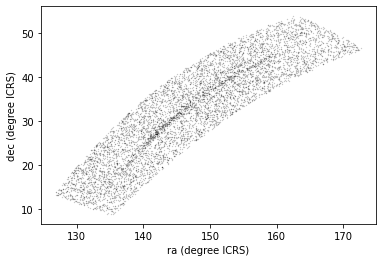

In [170]:
x = candidate_table['ra']
y = candidate_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

Here we can see more clearly the effect of transforming the coordinates.  In ICRS, it would be more difficulty to identity the stars near the centerline of GD-1.

So, before we move on to the next step, let's collect the code we used to transform the coordinates and make a Pandas `DataFrame`:

In [171]:
from pyia import GaiaData

def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    gaia_data = GaiaData(table)

    c_sky = gaia_data.get_skycoord(distance=8*u.kpc, 
                                   radial_velocity=0*u.km/u.s)
    c_gd1 = gc.reflex_correct(
                c_sky.transform_to(gc.GD1Koposov10))

    df = table.to_pandas()
    df['phi1'] = c_gd1.phi1
    df['phi2'] = c_gd1.phi2
    df['pm_phi1'] = c_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = c_gd1.pm_phi2
    return df

Here's how we can use this function:

In [172]:
candidate_df = make_dataframe(candidate_table)

And let's see the results.

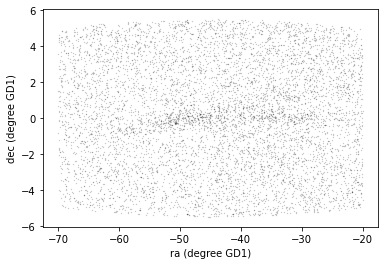

In [174]:
x = candidate_df['phi1']
y = candidate_df['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree GD1)')
plt.ylabel('dec (degree GD1)');

We're starting to see GD-1 more clearly.

We can compare this figure with one of these panels in Figure 1 from the original paper:

<img height="150" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-2.png">

<img height="150" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-4.png">

The top panel shows stars selected based on proper motion only, so it is comparable to our figure (although notice that it covers a wider region).

In the next lesson, we will use photometry data from Pan-STARRS to do a second round of filtering, and see if we can replicate the bottom panel.

We'll also learn how to add annotations like the ones in the figure from the paper, and customize the style of the figure to present the results clearly and compellingly.

## Saving the DataFrame

Let's save this `DataFrame` so we can pick up where we left off without running this query again.

In [175]:
!rm -f gd1_candidates.hdf5

In [176]:
filename = 'gd1_candidates.hdf5'

candidate_df.to_hdf(filename, 'candidate_df')

We can use `ls` to confirm that the file exists and check the size:

In [177]:
!ls -lh gd1_candidates.hdf5

-rw-rw-r-- 1 downey downey 756K Oct 15 14:33 gd1_candidates.hdf5


If you are using Windows, `ls` might not work; in that case, try:

```
!dir gd1_candidates.hdf5
```

## CSV

Pandas can write a variety of other formats, [which you can read about here](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

We won't cover all of them, but one other important one is [CSV](https://en.wikipedia.org/wiki/Comma-separated_values), which stands for "comma-separated values".

CSV is a plain-text format with minimal formatting requirements, so it can be read and written by pretty much any tool that works with data.  In that sense, it is the "least common denominator" of data formats.

However, it has an important limitation: some information about the data gets lost in translation, notably the data types.  If you read a CSV file from someone else, you might need some additional information to make sure you are getting it right.

Also, CSV files tend to be big, and slow to read and write.

With those caveats, here's how to write one:

In [178]:
candidate_df.to_csv('gd1_candidates.csv')

We can check the file size like this:

In [179]:
!ls -lh gd1_candidates.csv

-rw-rw-r-- 1 downey downey 1.6M Oct 15 14:33 gd1_candidates.csv


The CSV file about 2 times bigger than the HDF5 file (so that's not that bad, really).

We can see the first few lines like this:

In [180]:
!head -3 gd1_candidates.csv

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
0,635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859,0.7913934419894347,0.2717538145759051,,-59.63048941944396,-1.21648525150429,-7.361362712556612,-0.5926328820420083
1,635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,0.30745551377348623,0.19946557779138105,,-59.247329893833296,-2.0160784008206476,-7.527126084599517,1.7487794924398758


The CSV file contains the names of the columns, but not the data types.

We can read the CSV file back like this:

In [181]:
read_back_csv = pd.read_csv('gd1_candidates.csv')

Let's compare the first few rows of `candidate_df` and `read_back_csv`

In [182]:
candidate_df.head(3)

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,0.271754,NaN,-59.630489,-1.216485,-7.361363,-0.592633
1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,0.199466,NaN,-59.247330,-2.016078,-7.527126,1.748779
2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,NaN,-59.133391,-2.306901,-7.560608,-0.741800


In [183]:
read_back_csv.head(3)

,Unnamed: 0,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,phi1,phi2,pm_phi1,pm_phi2
0,0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,0.271754,NaN,-59.630489,-1.216485,-7.361363,-0.592633
1,1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,0.199466,NaN,-59.247330,-2.016078,-7.527126,1.748779
2,2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,0.223692,NaN,-59.133391,-2.306901,-7.560608,-0.741800


Notice that the index in `candidate_df` has become an unnamed column in `read_back_csv`.  The Pandas functions for writing and reading CSV files provide options to avoid that problem, but this is an example of the kind of thing that can go wrong with CSV files.

## Summary

In the previous notebook we downloaded a large dataset and then selected a small fraction of them based on proper motion.

In this notebook, we improved this process by writing a more complex query that uses the database to select stars based on proper motion.  This process requires more computation on the Gaia server, but then we're able to either:

1. Search the same region and download less data, or

2. Search a larger region while still downloading a manageable amount of data.

In the next lesson, we'll learn about the databased `JOIN` operation and use it to download photometry data from Pan-STARRS.

## Best practices

* When possible, "move the computation to the data"; that is, do as much of the work as possible on the database server before downloading the data.

* For most applications, saving data in FITS or HDF5 is better than CSV.  FITS and HDF5 are binary formats, so the files are usually smaller, and they store metadata, so you don't lose anything when you read the file back.

* On the other hand, CSV is a "least common denominator" format; that is, it can be read by practically any application that works with data.